In [20]:
import chex

chex.set_n_cpu_devices(4)

from functools import partial
import os
from pathlib import Path
import pickle
from typing import Literal, NamedTuple

from gabenet.mcmc import sample_markov_chain
from gabenet.nets import MultinomialDirichletBelieve, PoissonGammaBelieve
from gabenet.utils import freeze_trainable_states, perplexity
import haiku as hk
import jax
from jax import random
import jax.numpy as jnp
from scipy.stats import entropy

import sys
sys.path.append(str(Path('examples/mutational-signatures/').resolve()))
from dataset import load_mutation_spectrum, COSMIC_WEIGHTS


In [2]:
# Model hyperparameters.
MODEL: Literal[
    "multinomial_dirichlet_believe", "poisson_gamma_believe"
] = "multinomial_dirichlet_believe"
n_topics = len(COSMIC_WEIGHTS)
HIDDEN_LAYER_SIZES = [n_topics, n_topics]
GAMMA_0 = 10.0
_bottom_layer_name = (
    f"{MODEL}/~/multinomial_layer"
    if MODEL == "multinomial_dirichlet_believe"
    else f"{MODEL}/~/poisson_layer"
)
# Print out model hyperparameters for logging.
print(f"MODEL = {MODEL}")
print(f"n_topics = {n_topics}")
print(f"HIDDEN_LAYER_SIZES = {HIDDEN_LAYER_SIZES}")
print(f"GAMMA_0 = {GAMMA_0}")

n_features = 96
X_train, X_test = load_mutation_spectrum()


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


MODEL = multinomial_dirichlet_believe
n_topics = 78
HIDDEN_LAYER_SIZES = [78, 78]
GAMMA_0 = 10.0


In [3]:
X_train = X_train[:15]
X_test = X_test[:15]

In [4]:
X_train.sum(axis=1)

Array([7450., 2544., 2962., 6206., 1728., 5654., 3281., 4984., 6655.,
       6437., 6905., 6419., 1750., 4342., 8211.], dtype=float32)

In [5]:
@hk.transform_with_state
def kernel(X=X_train, freeze_phi=True):
    """Advance the Markov chain by one step."""
    if MODEL == "multinomial_dirichlet_believe":
        model = MultinomialDirichletBelieve(
            HIDDEN_LAYER_SIZES, n_features, gamma_0=GAMMA_0
        )
    else:
        model = PoissonGammaBelieve(HIDDEN_LAYER_SIZES, n_features, gamma_0=GAMMA_0)
    if freeze_phi:
        model.layers.layers[-1].set_training(False)
    # Do one Gibbs sampling step.
    model(X)

class TrainState(NamedTuple):
    params: hk.Params
    state: hk.State
    key: jax.Array  # type: ignore
    step: int


In [6]:
def probability(params, state):
    bottom_params = params.get(_bottom_layer_name, {})
    bottom_state = state[_bottom_layer_name]
    phi = bottom_params.get("phi", bottom_state.get("phi"))
    theta = bottom_state["copy[theta(1)]"]
    probs = theta @ phi
    probs /= probs.sum(axis=-1, keepdims=True)
    return probs


def initialise(key) -> TrainState:
    """Initialise training state."""
    key, subkey = random.split(key)
    keys = random.split(subkey, jax.device_count())
    params, state = jax.vmap(partial(kernel.init, freeze_phi=False))(keys)
    # params, state = freeze_trainable_states(state, variable_names=["phi"])
    state[_bottom_layer_name].pop("phi")
    params[_bottom_layer_name] = {'phi': jnp.array(COSMIC_WEIGHTS)}
    return TrainState(params, state, key, 0)

In [7]:
def evaluate(params, states, X, axis=[0, 1]):
    """Compute perplexity over chains and samples by default (axis=[0, 1])."""
    probs = probability(params, states).mean(axis)
    return perplexity(X, probs)

In [8]:
def train_step(train_state: TrainState, n_burnin=0) -> TrainState:
    """Do a set of Markov chain monte carlo steps and save checkpoint."""
    key_seq = hk.PRNGSequence(train_state.key)
    _, states = sample_markov_chain(
        next(key_seq),
        kernel=kernel,
        n_samples=8_000,
        n_burnin_steps=n_burnin,
        initial_state=train_state.state,
        params=train_state.params,
    )
    loss_train = evaluate(train_state.params, states, X_train)
    print(f"Training set perplexity: {loss_train:.2f}")
    loss_test = evaluate(train_state.params, states, X_test)
    print(f"Test set perplexity: {loss_test:.2f}")

    last_state = jax.tree_util.tree_map(lambda x: x[:, -1, ...], states)
    new_step = train_state.step + n_burnin + 100
    new_train_state = TrainState(
        train_state.params, last_state, next(key_seq), new_step
    )
    return states, new_train_state

In [9]:
key = jax.random.PRNGKey(42)
train_state = initialise(key)

loss_test = evaluate(train_state.params, train_state.state, X_test, axis=[0])
print("Initial perplexity on test set", loss_test)
states, train_state = train_step(train_state)

Initial perplexity on test set 113.041725
Training set perplexity: 62.63
Test set perplexity: 62.54


In [32]:
import arviz as az

r_entr = entropy(states["multinomial_dirichlet_believe/~/cap_layer"]["r"], axis=-1)
theta_2_entr = entropy(states["multinomial_dirichlet_believe/~/cap_layer"]["theta"], axis=-1)
theta_1_entr = entropy(states["multinomial_dirichlet_believe/~/dirichlet_layer"]["theta"], axis=-1)

idata = az.convert_to_dataset(
    {
        "c_cap": states["multinomial_dirichlet_believe/~/cap_layer"]['c'],
        "c_mid": states["multinomial_dirichlet_believe/~/dirichlet_layer"]["c"],
        "s[r]": r_entr,
        "s[theta(2)]": theta_2_entr,
        "s[theta(1)]": theta_1_entr,
    }
)

In [33]:
result = az.summary(idata, round_to=2)
result

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c_cap,0.20,0.35,0.00,0.81,0.06,0.05,26.98,55.03,1.10
c_mid,17.54,3.94,8.08,23.04,0.75,0.53,33.87,58.35,1.07
s[r],1.73,0.40,0.96,2.53,0.04,0.03,122.32,59.03,1.02
s[theta(2)][0],0.07,0.24,0.00,0.45,0.04,0.03,40.43,53.42,1.07
s[theta(2)][1],0.09,0.27,0.00,0.68,0.05,0.04,35.72,39.71,1.07
s[theta(2)][2],0.07,0.22,0.00,0.39,0.03,0.02,38.43,48.26,1.07
s[theta(2)][3],0.08,0.24,0.00,0.51,0.04,0.03,34.55,54.57,1.07
s[theta(2)][4],0.07,0.23,0.00,0.51,0.04,0.03,32.84,44.47,1.08
s[theta(2)][5],0.19,0.31,0.00,0.71,0.11,0.08,10.59,47.97,1.28
s[theta(2)][6],0.08,0.25,0.00,0.58,0.04,0.03,33.39,69.62,1.07


In [34]:
entry_theta_1_convergence = az.summary(idata, var_names='s[theta(1)]', round_to=2)
entry_theta_1_convergence['r_hat'].max()

1.21

array([[<AxesSubplot:title={'center':'s[r]'}>,
        <AxesSubplot:title={'center':'s[r]'}>]], dtype=object)

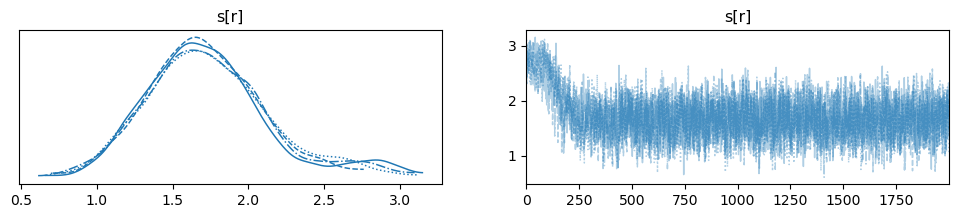

In [25]:
az.plot_trace(idata['s[r]'])

array([[<AxesSubplot:title={'center':'c_cap'}>,
        <AxesSubplot:title={'center':'c_cap'}>]], dtype=object)

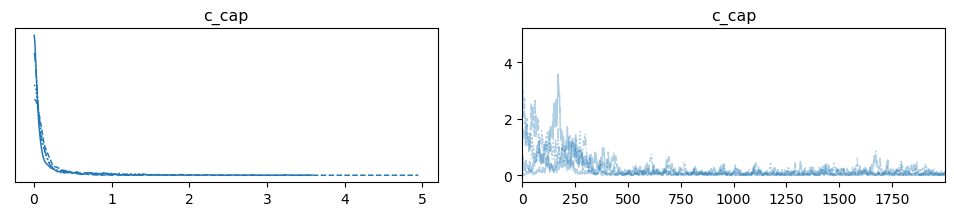

In [35]:
az.plot_trace(idata['c_cap'])